In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
from dateutil.relativedelta import relativedelta
import warnings    
import math
import time
import re
import os
import pickle
from math import pi

from lifetimes import BetaGeoFitter, GammaGammaFitter

from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

warnings.filterwarnings('ignore')
plt.style.use(style = 'tableau-colorblind10')
plt.rcParams['figure.figsize'] = (15, 10)
os.getcwd()

'D:\\PetProject\\MarketingMIx'

In [2]:
file_path = '\\Data\\Transactions.csv'

dtypes = {'transaction_id' : str, 'cust_id' : str, 'tran_date' : str, 'prod_subcat_code' : str,
          'prod_cat_code' : str, 'Qty' : float, 'Rate' : float, 'Tax' : float, 'total_amt' : float,
          'Store_type' : str}

In [3]:
transactions = pd.read_csv(os.getcwd()+file_path, dtype = dtypes)
transactions['tran_date'] = pd.to_datetime(transactions['tran_date'])
transactions.head()

,transaction_id,cust_id,tran_date,prod_subcat_code,prod_cat_code,Qty,Rate,Tax,total_amt,Store_type
0,80712190438,270351,2014-02-28,1,1,-5.0,-772.0,405.300,-4265.300,e-Shop
1,29258453508,270384,2014-02-27,5,3,-5.0,-1497.0,785.925,-8270.925,e-Shop
2,51750724947,273420,2014-02-24,6,5,-2.0,-791.0,166.110,-1748.110,TeleShop
3,93274880719,271509,2014-02-24,11,6,-3.0,-1363.0,429.345,-4518.345,e-Shop
4,51750724947,273420,2014-02-23,6,5,-2.0,-791.0,166.110,-1748.110,TeleShop


In [4]:
transactions.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23053 entries, 0 to 23052
Data columns (total 10 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   transaction_id    23053 non-null  object        
 1   cust_id           23053 non-null  object        
 2   tran_date         23053 non-null  datetime64[ns]
 3   prod_subcat_code  23053 non-null  object        
 4   prod_cat_code     23053 non-null  object        
 5   Qty               23053 non-null  float64       
 6   Rate              23053 non-null  float64       
 7   Tax               23053 non-null  float64       
 8   total_amt         23053 non-null  float64       
 9   Store_type        23053 non-null  object        
dtypes: datetime64[ns](1), float64(4), object(5)
memory usage: 1.8+ MB


In [5]:
results_path = '\\Results\\'

infile = open(os.getcwd() + results_path + 'segments_df_list.pkl','rb')
segments_df_list = pickle.load(infile)
infile.close()

segments_df_list[0].head()

,cust_id,Recency,Frequency,MonetaryValue,Age,Gender_F,Gender_M,City_1,City_10,City_2,...,Electronics_Computers,Electronics_Mobiles,Electronics_Personal Appliances,Footwear_Kids,Footwear_Mens,Footwear_Women,Home and kitchen_Bath,Home and kitchen_Furnishing,Home and kitchen_Kitchen,Home and kitchen_Tools
0,266783,710,4,14791.530,40.934247,0,1,0,0,0,...,0.0,0.0,0.00,0.0000,0.00,0.0000,0.0,0.0,0.0,0.0
1,266784,150,3,5694.065,22.986301,1,0,0,1,0,...,0.0,442.0,0.00,0.0000,0.00,0.0000,0.0,0.0,0.0,0.0
2,266785,701,7,35271.600,29.446575,1,0,0,0,0,...,0.0,0.0,0.00,5023.8825,2908.36,0.0000,0.0,0.0,0.0,0.0
3,266788,811,4,6092.970,42.731507,1,0,0,0,1,...,0.0,0.0,0.00,1927.1200,1312.74,0.0000,0.0,0.0,0.0,0.0
4,266794,1355,11,28253.745,43.789041,1,0,0,0,0,...,0.0,0.0,4610.06,0.0000,0.00,2240.3875,0.0,0.0,0.0,0.0


In [6]:
first_prch_date = transactions.groupby(['cust_id']).agg({
                                                'tran_date' : 'min'
                                                })
first_prch_date.columns = ['first_prch_date']

first_prch_date = first_prch_date[['first_prch_date']]
first_prch_date.reset_index(inplace=True)
first_prch_date.head()

,cust_id,first_prch_date
0,266783,2011-09-23
1,266784,2012-04-12
2,266785,2011-03-15
3,266788,2011-09-13
4,266794,2011-03-18


In [7]:
periods = ['2014-12-02', '2014-05-02', '2013-12-02']
business_rule_period = 3
churn_analysis_list = []

for df, i in zip(segments_df_list, periods):
    
    max_date = dt.datetime.strptime(i , "%Y-%m-%d")
    df = pd.merge(df, first_prch_date, how='left', on=['cust_id'])
    
    tmp = transactions[transactions.tran_date <= i]
    last_prch_date = tmp.groupby(['cust_id']).agg({
                                                'tran_date' : 'max'
                                                })
    last_prch_date.columns = ['last_prch_date']
    last_prch_date = last_prch_date[['last_prch_date']]
    last_prch_date.reset_index(inplace=True)
    
    df = pd.merge(df, last_prch_date, how='left', on=['cust_id'])
    
    df['prch_periods'] =  round(((df['last_prch_date'] - df['first_prch_date'])/ np.timedelta64(1,'D'))/365*12,0)
    df['Frequency_Month'] = round(df['prch_periods']/df['Frequency'],0)
    
    df['months_from_last_prch'] =  round(((max_date- df['last_prch_date'])/ np.timedelta64(1,'D'))/365*12,0)
      
    df['Churn_Status'] = np.where(df['Frequency_Month'] == 0, 'New_Customer', 
                                 np.where(df['Frequency_Month'] * business_rule_period < df['months_from_last_prch'], 'Churn', 'Not_Churn'))
    
    churn_analysis_list.append(df)

In [8]:
rule_base_churn = pd.DataFrame(columns = ['Churn_Status','count','Period'])

for df, i in zip(churn_analysis_list, periods):
    
    tmp = pd.DataFrame(df.groupby(['Churn_Status']).size(), columns = ['count'])
    tmp = tmp[['count']]
    tmp.reset_index(inplace=True)
    tmp['Period'] = i
    rule_base_churn = pd.concat([rule_base_churn, tmp])
    
rule_base_churn.to_csv(os.getcwd() + results_path + 'rule_base_churn.csv',index=False)

In [9]:
rule_base_churn

,Churn_Status,count,Period
0,Churn,2241,2014-12-02
1,New_Customer,553,2014-12-02
2,Not_Churn,2712,2014-12-02
0,Churn,1256,2014-05-02
1,New_Customer,571,2014-05-02
2,Not_Churn,3671,2014-05-02
0,Churn,953,2013-12-02
1,New_Customer,676,2013-12-02
2,Not_Churn,3832,2013-12-02


In [10]:
rule_base_churn_loss = pd.DataFrame(columns = ['monetary_lost','Period'])

for df, i in zip(churn_analysis_list, periods):
    
    tmp = df[(df.Churn_Status == 'Churn')&(df.MonetaryValue > 0)]
    tmp['monetary_lost'] = tmp.months_from_last_prch/tmp.Frequency_Month * tmp.MonetaryValue/tmp.Frequency
    tmp = pd.DataFrame([[tmp['monetary_lost'].sum()]], columns = ['monetary_lost']) 
    tmp['Period'] = i
    rule_base_churn_loss = pd.concat([rule_base_churn_loss, tmp])    

rule_base_churn_loss.to_csv(os.getcwd() + results_path + 'rule_base_churn_loss.csv',index=False)

In [11]:
rfm_list = []

for i in periods:
    
    df = transactions[transactions.tran_date <= i]
    
    today_date = dt.datetime.strptime(i , "%Y-%m-%d")
    
    rfm = df.groupby("cust_id").agg({"tran_date": [lambda date: (date.max() - date.min()).days,
                                                     lambda date: (today_date - date.min()).days],
                                     "transaction_id": lambda num: num.nunique(),
                                      "total_amt": lambda price: abs(price).sum()}) #total price per customer

    rfm.columns = rfm.columns.droplevel(0)
    rfm.columns = ['Recency', "T", 'Frequency', "Monetary"]

    rfm["Monetary"] = rfm["Monetary"] / rfm["Frequency"]
    rfm_list.append(rfm)

rfm_list[0].head()

,Recency,T,Frequency,Monetary
cust_id,,,,
266783,710,1166,4,3697.882500
266784,150,964,3,1898.021667
266785,701,1358,7,5038.800000
266788,811,1176,4,1523.242500
266794,1355,1355,11,2568.522273


In [12]:
btyd = pd.DataFrame(columns = ['Recency','T','Frequency','Monetary','expctd_num_of_purch',
                              'conditional_probability_alive','expct_avg_spend','cltv_half_year','Period'])

for df, i in zip(rfm_list, periods):
    
    df["Frequency"] = df["Frequency"].astype(int)
    df["Monetary"] = np.where(df['Monetary']<0, 0, df['Monetary'])

    bgf = BetaGeoFitter(penalizer_coef=0.001)
    bgf.fit(df['Frequency'], df['Recency'], df['T'])
    df['expctd_num_of_purch'] = bgf.predict(180, df['Frequency'], df['Recency'], df['T'])
    df['conditional_probability_alive'] = bgf.conditional_probability_alive(df['Frequency'], df['Recency'], df['T'])
    
    ggf = GammaGammaFitter(penalizer_coef=0.01)
    ggf.fit(df['Frequency'], df['Monetary'])
    
    df["expct_avg_spend"] = ggf.conditional_expected_average_profit(df['Frequency'], df['Monetary'])
    
    df["cltv_half_year"] = ggf.customer_lifetime_value(bgf,
                                   df['Frequency'],
                                   df['Recency'],
                                   df['T'],
                                   df['Monetary'],
                                   time=6,  # 12 month
                                   freq="D",  # frequency of T
                                   discount_rate=0.01)
    df['Period'] = i
    btyd = pd.concat([btyd, df])    

        
btyd.to_csv(os.getcwd() + results_path + 'btyd.csv')

Text(0, 0.5, 'Density')

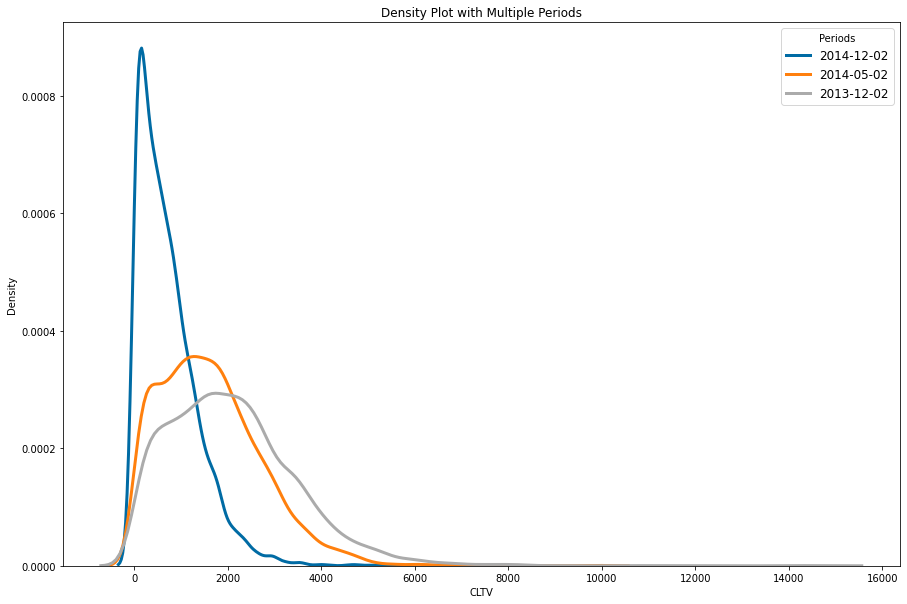

In [13]:
plt.figure(figsize = (15, 10))
for period in periods:
    # Subset to the airline
    subset = btyd[btyd['Period'] == period]
    
    # Draw the density plot
    sns.distplot(subset['cltv_half_year'], hist = False, kde = True,
                 kde_kws = {'linewidth': 3},
                 label = period)
    
# Plot formatting
plt.legend(prop={'size': 12}, title = 'Periods')
plt.title('Density Plot with Multiple Periods')
plt.xlabel('CLTV')
plt.ylabel('Density')

In [14]:
btyd['Period'].unique()

array(['2014-12-02', '2014-05-02', '2013-12-02'], dtype=object)

In [15]:
tmp = pd.DataFrame(btyd[btyd.Period == '2014-05-02']['conditional_probability_alive'])
tmp.reset_index(inplace=True)
tmp['conditional_probability_alive'] = 1-tmp['conditional_probability_alive']
tmp.columns = ['cust_id', 'probability_churn']

In [16]:
train_df = segments_df_list[2]

train_df = train_df.merge(tmp, on='cust_id')

train_df.head()

,cust_id,Recency,Frequency,MonetaryValue,Age,Gender_F,Gender_M,City_1,City_10,City_2,...,Electronics_Mobiles,Electronics_Personal Appliances,Footwear_Kids,Footwear_Mens,Footwear_Women,Home and kitchen_Bath,Home and kitchen_Furnishing,Home and kitchen_Kitchen,Home and kitchen_Tools,probability_churn
0,266783,710,4,14791.530,39.934247,0,1,0,0,0,...,0.0,0.00,0.0000,0.00,0.000,0.0,0.0,0.0,0.0,0.236598
1,266784,150,3,5694.065,21.986301,1,0,0,1,0,...,442.0,0.00,0.0000,0.00,0.000,0.0,0.0,0.0,0.0,0.772453
2,266785,701,7,35271.600,28.446575,1,0,0,0,0,...,0.0,0.00,5023.8825,2908.36,0.000,0.0,0.0,0.0,0.0,0.512888
3,266788,811,4,6092.970,41.731507,1,0,0,0,1,...,0.0,0.00,1927.1200,1312.74,0.000,0.0,0.0,0.0,0.0,0.159266
4,266794,835,10,27542.125,42.789041,1,0,0,0,0,...,0.0,4610.06,0.0000,0.00,3769.155,0.0,0.0,0.0,0.0,0.326287


In [17]:
tmp = pd.DataFrame(btyd[btyd.Period == '2014-12-02']['conditional_probability_alive'])
tmp.reset_index(inplace=True)
tmp['conditional_probability_alive'] = 1-tmp['conditional_probability_alive']
tmp.columns = ['cust_id', 'probability_churn']

In [18]:
test_df = segments_df_list[1]

test_df = test_df.merge(tmp, on='cust_id')

test_df.head()

,cust_id,Recency,Frequency,MonetaryValue,Age,Gender_F,Gender_M,City_1,City_10,City_2,...,Electronics_Mobiles,Electronics_Personal Appliances,Footwear_Kids,Footwear_Mens,Footwear_Women,Home and kitchen_Bath,Home and kitchen_Furnishing,Home and kitchen_Kitchen,Home and kitchen_Tools,probability_churn
0,266783,710,4,14791.530,40.347945,0,1,0,0,0,...,0.0,0.00,0.0000,0.00,0.000,0.0,0.0,0.0,0.0,0.654957
1,266784,150,3,5694.065,22.400000,1,0,0,1,0,...,442.0,0.00,0.0000,0.00,0.000,0.0,0.0,0.0,0.0,0.959002
2,266785,701,7,35271.600,28.860274,1,0,0,0,0,...,0.0,0.00,5023.8825,2908.36,0.000,0.0,0.0,0.0,0.0,0.900346
3,266788,811,4,6092.970,42.145205,1,0,0,0,1,...,0.0,0.00,1927.1200,1312.74,0.000,0.0,0.0,0.0,0.0,0.530817
4,266794,835,10,27542.125,43.202740,1,0,0,0,0,...,0.0,4610.06,0.0000,0.00,3769.155,0.0,0.0,0.0,0.0,0.093626


In [19]:
x_train, y_train = train_df.iloc[:,1:42], train_df['probability_churn']
x_test, y_test = test_df.iloc[:,1:42], test_df['probability_churn']

In [20]:
scaler = StandardScaler()
scaler.fit(x_train)
x_train_scaled_values = scaler.transform(x_train)

In [21]:
scaler_test = StandardScaler()
scaler_test.fit(x_test)
x_test_scaled_values = scaler_test.transform(x_test)

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

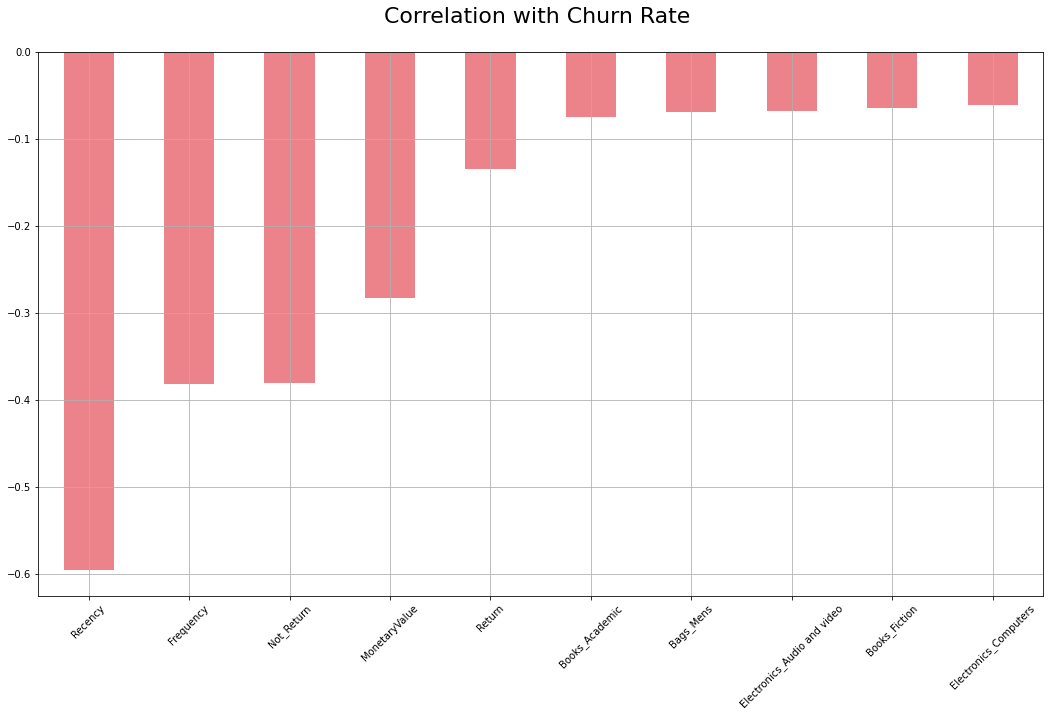

In [22]:
data_cor = pd.DataFrame(x_train_scaled_values, columns = x_train.columns)

correlations = data_cor.corrwith(y_train)

correlations = correlations[correlations!=1]
correlations = correlations.sort_values().head(10)
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 10, 
        color = '#ec838a',
        rot = 45, grid = True)
plt.title('Correlation with Churn Rate \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

Text(0.5, 1.0, 'Correlation with Churn Rate \n')

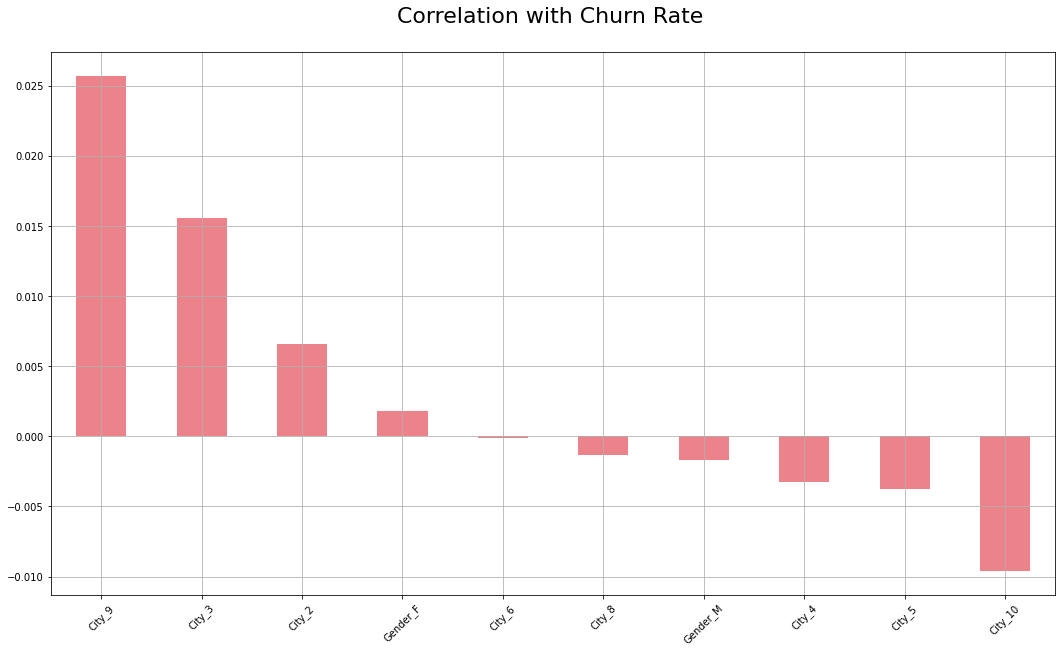

In [23]:
data_cor = pd.DataFrame(x_train_scaled_values, columns = x_train.columns)

correlations = data_cor.corrwith(y_train)

correlations = correlations[correlations!=1]
correlations = correlations.sort_values(ascending=False).head(10)
correlations.plot.bar(
        figsize = (18, 10), 
        fontsize = 10, 
        color = '#ec838a',
        rot = 45, grid = True)
plt.title('Correlation with Churn Rate \n',
horizontalalignment="center", fontstyle = "normal", 
fontsize = "22", fontfamily = "sans-serif")

In [54]:
import pandas as pd
import xgboost as xgb
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error

In [28]:
params = { 'max_depth': [3,6,10],
           'learning_rate': [0.01, 0.05, 0.1],
           'n_estimators': [100, 500, 1000],
           'colsample_bytree': [0.3, 0.7]}

In [29]:
xgbr = xgb.XGBRegressor(seed = 20)

In [30]:
reg = GridSearchCV(estimator=xgbr, 
                   param_grid=params,
                   scoring='neg_mean_squared_error', 
                   verbose=1)

In [31]:
reg.fit(x_train_scaled_values, y_train)
print("Best parameters:", reg.best_params_)
print("Lowest RMSE: ", (-reg.best_score_)**(1/2.0))

Fitting 5 folds for each of 54 candidates, totalling 270 fits
Best parameters: {'colsample_bytree': 0.7, 'learning_rate': 0.01, 'max_depth': 3, 'n_estimators': 500}
Lowest RMSE:  0.20571986724155927


In [49]:
y_pred = reg.predict(x_test_scaled_values)
mse = mean_squared_error(y_test, y_pred)
print("MSE: ")
print(mse)

MSE: 
0.12420425300704425


In [55]:
xgb = XGBRegressor(colsample_bytree=0.7,
                  learning_rate = 0.01,
                  max_depth = 3,
                  n_estimators = 500)
xgb.fit(x_train_scaled_values, y_train)

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.01, max_delta_step=0, max_depth=3,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=500, n_jobs=12, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

<BarContainer object of 41 artists>

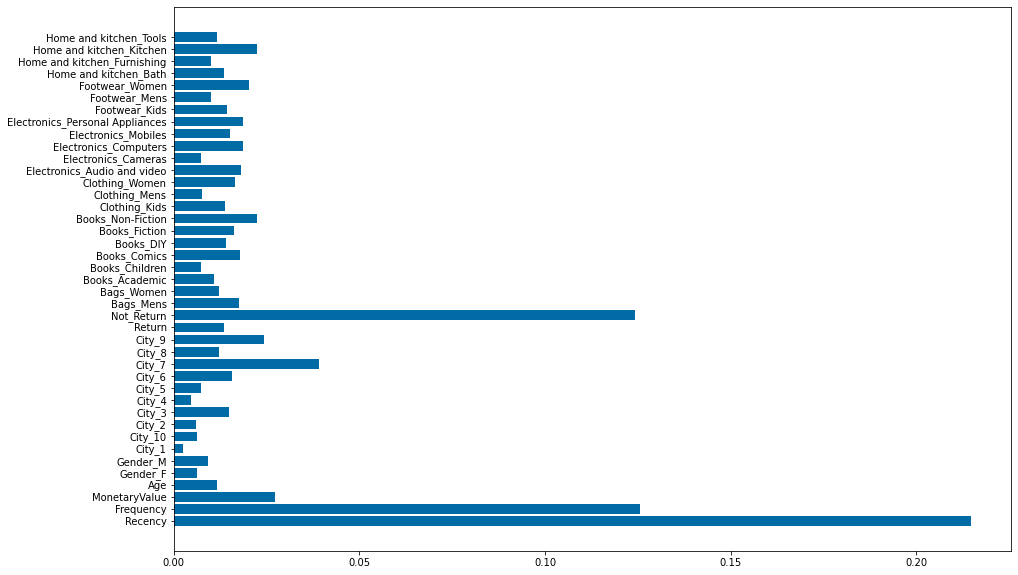

In [56]:
plt.barh(x_train.columns, xgb.feature_importances_)

In [57]:
import shap

In [69]:
explainer = shap.TreeExplainer(xgb)
shap_values = explainer.shap_values(x_test_scaled_values)

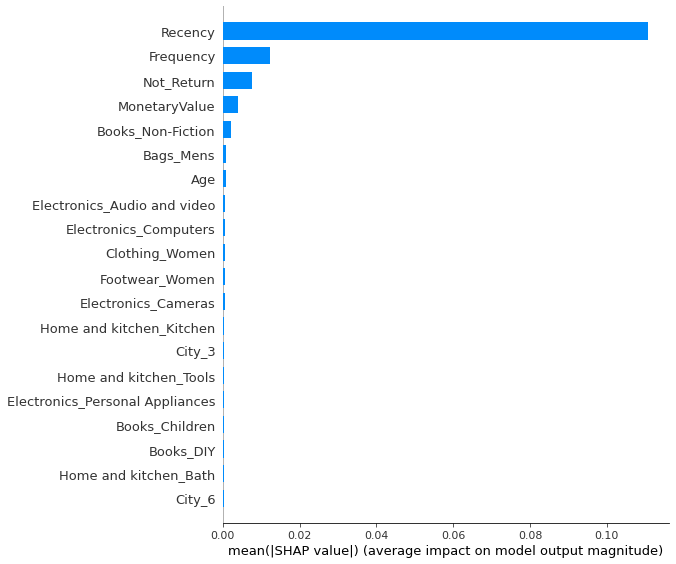

In [62]:
shap.summary_plot(shap_values, x_test_scaled_values, feature_names = x_train.columns.tolist(), plot_type="bar")

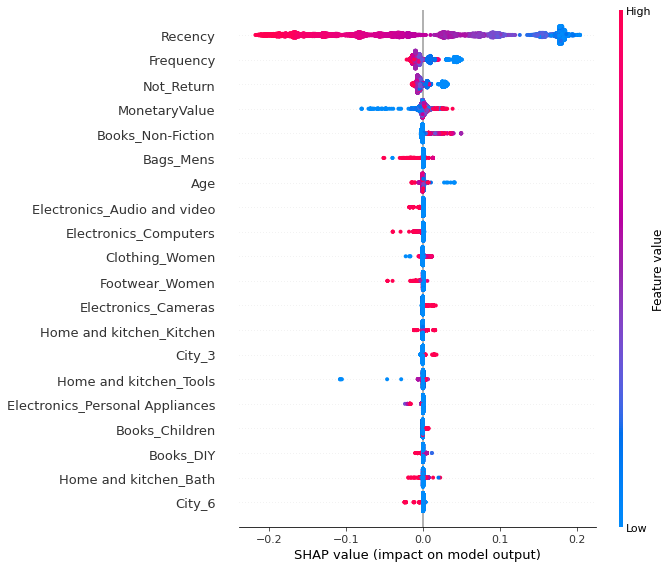

In [63]:
shap.summary_plot(shap_values, x_test_scaled_values, feature_names = x_train.columns.tolist())

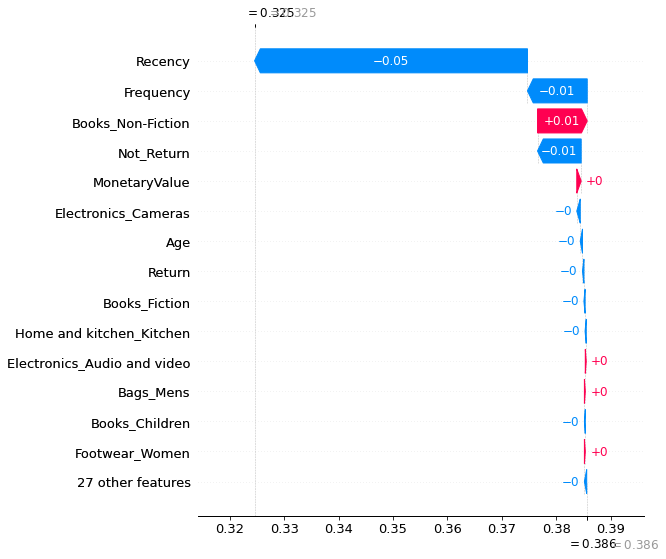

In [79]:
shap.plots._waterfall.waterfall_legacy(explainer.expected_value, shap_values[0],
                                       feature_names = x_train.columns.tolist(), max_display = 15)